In [444]:
import requests
import json
from pprint import pprint
import pandas as pd

def priceToken0(swap):
    """
    Converting from Uniswap's SqrtPriceX96 quantity
    to a de-sqrt'ed, de-X96'ed, and de-decimalized number.
    
    This gives the price of token1 in units of token0.
    
    Reference: https://docs.uniswap.org/sdk/v3/guides/fetching-prices
    """
    d0 = int(swap["pool"]["token0"]["decimals"])
    d1 = int(swap["pool"]["token1"]["decimals"])

    p_smol = float(swap["sqrtPriceX96"])**2 / (2**192)
    
    p = p_smol * (10**(-d1)) / (10**(-d0))
    
    return p

def priceToken1(swap):
    """
    This gives the price of token1 in units of token0.
    """
    return 1/priceToken0(swap)

def prepswapdata(swaps):    
    rows = []
    router_addresses = {
        "0xe592427a0aece92de3edee1f18e0157c05861564", # V3 router
        "0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45", # V3 router 2
        "0x881d40237659c251811cec9c364ef91dc08d300c", # metamask
        "0x1111111254fb6c44bac0bed2854e76f90643097d", # 1inch V4 aggregation router
        "0x1111111254eeb25477b68fb85ed929f73a960582", # 1inch V5 aggregation router
        "0x53222470cdcfb8081c0e3a50fd106f0d69e63f20", # 1inch unlabeled
    }
    for swap in swaps:
        rows.append(
            {
                "amount0": float(swap["amount0"]),
                "amount1": float(swap["amount1"]),
                "boughtToken0": 1 if (float(swap["amount0"]) < 0) else 0, # it's a buy if amount0 is positive
                "viaRouter": 1 if (swap["sender"] in router_addresses) else 0,
                "price0After": priceToken0(swap),
                "price1After": priceToken1(swap),
                "blockNumber": int(swap["transaction"]["blockNumber"]),
                "logIndex": int(swap["logIndex"]),
                "blockTimestamp": float(swap["timestamp"]),
                "txnHash": swap["transaction"]["id"],
                "origin": swap["origin"],
            }
        )
    
    df = pd.DataFrame(rows)
    df = df.sort_values(by=["blockNumber", "logIndex"], ascending=True) # sorts the transactions by occurrence within the block
    return df

def getswaps(pool, cutoff_timestamp=1668227632):
    """
    Get all of the Uniswap swaps on a particular pool, back
    to a specific time `cutoff_timestamp`.
    
    pool: str
    cutoff_timestamp: int
    """
    pool = pool.lower().strip()
    url = "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3"
    allswaps = []
    sup_timestamp = 10**15 # greates that the timestamp can be, on each round of pagination
    
    for i in range(1_001):
        print("i:", i)
        
        query = '''
        {
            swaps(
                first: 1000, 
                orderBy: timestamp, 
                orderDirection: desc,
                where: {
                    pool: "%s",
                    timestamp_lte: %d
                    #timestamp_gt: %d
                }
            ) {
                amount0
                amount1
                amountUSD
                timestamp
                sqrtPriceX96
                tick
                logIndex
                sender
                origin

                pool {
                    token0 {
                        id
                        symbol
                        decimals
                    }
                    token1 {
                        id
                        symbol
                        decimals
                    }
                    #feesUSD
                    #txCount
                    #observationIndex
                    #collectedFeesUSD
                    #collectedFeesToken0
                    #collectedFeesToken1
                }
                
                transaction {
                    blockNumber,
                    id
                    
                }
            }
        }
        ''' % (
            pool,
            sup_timestamp,
            cutoff_timestamp
        )

        result = json.loads(requests.post(
            url,
            json={"query": query}
        ).content)

        if ("data" not in result) or (len(result["data"]["swaps"]) == 0):
            pprint(result)
            print("breaking a")
            break

        swaps = result["data"]["swaps"]


        # linear-time search for the last timestamp; can be optimized to O(log(n)), but not worth it rn
        j = len(swaps)
        while int(swaps[j-1]["timestamp"]) < cutoff_timestamp:
            j -= 1

        if sup_timestamp == int(swaps[j-1]["timestamp"]):
            # note, this could be problematic if we had >1,000 swaps that all had the same timestamp
            print("done, since we have the same sup_timestamp as before")
            break
        else:
            sup_timestamp = int(swaps[j-1]["timestamp"]) # set the maximum time
            print("sup timestamp", sup_timestamp, "\n")

        # concatenate all swaps that have timestamp >= cutoff_timestamp
        allswaps += swaps[:j]
        if j != len(swaps):
            print("done, since the final swap is in the interior of the result batch")
            break
            
    pprint(allswaps[-1])
            
    return prepswapdata(allswaps)


In [445]:
swaps_ = getswaps("0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640", 1671062760)
swaps_

i: 0
sup timestamp 1671138635 

i: 1
sup timestamp 1671126167 

i: 2
sup timestamp 1671115319 

i: 3
sup timestamp 1671105359 

i: 4
sup timestamp 1671092111 

i: 5
sup timestamp 1671081419 

i: 6
sup timestamp 1671069971 

i: 7
sup timestamp 1671062771 

done, since the final swap is in the interior of the result batch
{'amount0': '-22223.877398',
 'amount1': '17',
 'amountUSD': '22244.06178678626004084444294111272',
 'logIndex': '178',
 'origin': '0x69d52023178740a87b7fa05c9b8921791a4dc0ca',
 'pool': {'token0': {'decimals': '6',
                     'id': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',
                     'symbol': 'USDC'},
          'token1': {'decimals': '18',
                     'id': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
                     'symbol': 'WETH'}},
 'sender': '0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45',
 'sqrtPriceX96': '2190742427558338425649492971662828',
 'tick': '204558',
 'timestamp': '1671062771',
 'transaction': {'blockNumber': '16186

,amount0,amount1,boughtToken0,viaRouter,price0After,price1After,blockNumber,logIndex,blockTimestamp,txnHash,origin
7717,-22223.877398,17.000000,1,1,0.000765,1307.905991,16186408,178,1.671063e+09,0x81c10ca555a95c360ba3fbcf168b1fccfb26a932eacc...,0x69d52023178740a87b7fa05c9b8921791a4dc0ca
7716,-172.820489,0.132201,1,1,0.000765,1307.905448,16186409,32,1.671063e+09,0x069715917723d547b9f1234f70b5ed5849656598ed89...,0xe1cf62a31c1561a40472eeef42966a056ba64864
7714,-38174.692721,29.203594,1,0,0.000765,1307.785604,16186409,38,1.671063e+09,0xc96daab972bb5942e978cf0a04112545f4bbb114302c...,0xfb9779477e5b4834bf2bc02dd29b97b344d0f700
7715,-620.395716,0.474624,1,1,0.000765,1307.783656,16186409,57,1.671063e+09,0x182e01d6768f3114f9dd1d3306bb36817a2f765618c9...,0xc07c7a221f9e26f3fd77deb2a5255d7dd1a63ec0
7713,-3809.343023,2.914294,1,1,0.000765,1307.771697,16186411,326,1.671063e+09,0xba2964fc7858c74615972d6fb9948a059a6f7df3b34b...,0x9a25d79ab755718e0b12bd3c927a010a543c2b31
...,...,...,...,...,...,...,...,...,...,...,...
4,1127.742657,-0.890000,0,1,0.000790,1266.494460,16193574,185,1.671149e+09,0xb59e27a6696aa9370058f4b4de33b5b3a85206c456ed...,0xd057299123251e663d352b2f94d6b0fd83f31f5f
3,-2519.080844,1.990019,1,1,0.000790,1266.488006,16193575,13,1.671149e+09,0x2e5d0c992084df9fd63801b7a942fb425c851e41867e...,0x89b537d4e0de035303dc1bdae18394f7a6c15c36
2,-316.463589,0.250000,1,1,0.000790,1266.487195,16193575,38,1.671149e+09,0xf1f9eb71f5c9652391684400801f3f4b742a2a5961bf...,0x3e27d0cee58273fff8053043963d0c49bf5dfee7
1,382.696002,-0.302020,0,1,0.000790,1266.488175,16193575,289,1.671149e+09,0xf23a8788e0ab4e1e1e6664098ba4355bea6f21f8efdc...,0xceb6dd944b16ca8463772b2ef3703a2001f5fda6


In [408]:
# swaps_[swaps_.blockNumber == 16192145] # 92 then 112, in order

d_ = swaps_[swaps_.blockNumber == 16192846]
for i_ in range(len(d_)):
    print(d_.iloc[i_].txnHash) # txnPosition: [126, 111, 169]; li: [154, 125, 206]
d_

0xac7d4c58601a0148307316a5d1076cd9e2681b848d4ff86d0f61594f0ea6512d
0x09fc9d163abb7bc95533745f3d5172cf316533a4ea4f1dac0a330ad8b9a3b7b8


,amount0,amount1,boughtToken0,viaRouter,price0After,price1After,blockNumber,logIndex,blockTimestamp,txnHash,origin
784,-32943.634352,26.000000,1,1,0.000789,1267.696230,16192846,36,1.671141e+09,0xac7d4c58601a0148307316a5d1076cd9e2681b848d4f...,0x2d8719cf0fe19782140ae16eec03938a96f5228b
785,1189.500000,-0.937846,0,1,0.000789,1267.699402,16192846,104,1.671141e+09,0x09fc9d163abb7bc95533745f3d5172cf316533a4ea4f...,0xe42ba48f3cc71424d9fb573e8312abecd2b152c2


## Getting Relative Block Position
We'll need to create a table that sorts the Uniswap orders by their occurrence inside the block, since this is not provided by the graph API. Arghhh.

Block position will be findable via Alchemy's [eth_getTrasactionByHash](https://docs.alchemy.com/reference/eth-gettransactionbyhash) API method. The issue is that this will require _a lot_ of queries. And it requires a full node to support it. Arghhh.

EDIT - I was able to use `swap.logIndex` to order the transactions. Yeet!

## What next?
* Implement multiple `is_informed()` txn filters.

In [409]:
# is_informed() filters. 1=informed, 0=uninformed

eps_ = 1e-10
has_lte_5_dec = lambda x: (((x%1) % 1e-5)/(1e-5) < eps_) or (1-((x%1) % 1e-5)/(1e-5) < eps_)
xnor = lambda a, b: (a and b) or ((not a) and (not b))

def is_informed1(swaps_in_block, swap_index):
    """
    Checks if either of the swaps have more than 5 decimals of precision.
    The idea is that uninformed flow typically won't use many decimals.
    Otherwise, we assume that it's an informed order.
    """
    swap = swaps_in_block.iloc[swap_index]
#     print(swap.amount0, has_lte_5_dec(swap.amount0))
#     print(swap.amount1, has_lte_5_dec(swap.amount1))
#     print()
    return not (has_lte_5_dec(swap.amount0) or has_lte_5_dec(swap.amount1))
    
def is_informed2(swaps_in_block, swap_index):
    """
    Checks if the next trade is in the opposite direction. If it's in the opposite
    direction, then we assume that this trade is uninformed. If it's in the same
    direction, then we assume that this trade is informed.
    """
    swap = swaps_in_block.iloc[swap_index]
    if swap_index+1 >= len(swaps_in_block):
        return -1
    
    next_swap = swaps_in_block.iloc[swap_index+1]
    
    return (
        ((swap.boughtToken0==1) and (next_swap.boughtToken0==1)) or 
        ((swap.boughtToken0==0) and (next_swap.boughtToken0==0))
    )
    
#     return xnor(swap.boughtToken0, next_swap.boughtToken0)

def is_informed3(swaps_in_block, swap_index):
    """
    Checks if an order went through the Uniswap V3 router.
    """
    swap = swaps_in_block.iloc[swap_index]
    return False if (swap.viaRouter == 1) else True

def is_informed_agg(swaps_in_block, swap_index):
    return (
#         is_informed1(swaps_in_block, swap_index) and
#         is_informed2(swaps_in_block, swap_index) and
        is_informed3(swaps_in_block, swap_index)
    )

def informedness(swaps):
    blocknumbers = swaps.blockNumber.unique()
    informedness_vals = []
    for blocknum in blocknumbers:
        swaps_in_block = swaps[swaps.blockNumber == blocknum]
        for swap_index in range(len(swaps_in_block)):
            informedness_vals.append([
#                 is_informed1(swaps_in_block, swap_index),
#                 is_informed2(swaps_in_block, swap_index),
#                 is_informed3(swaps_in_block, swap_index),
                is_informed_agg(swaps_in_block, swap_index),
#                 swaps_in_block.iloc[swap_index].viaRouter,
                swaps_in_block.iloc[swap_index].amount0,
#                 swaps_in_block.iloc[swap_index].amount1,
                swaps_in_block.iloc[swap_index].origin,
                swaps_in_block.iloc[swap_index].txnHash,
#                 swaps_in_block.iloc[swap_index].blockNumber,
#                 swaps_in_block.iloc[swap_index].logIndex,
            ])
        
    return informedness_vals



In [410]:
s_ = list(sorted(informedness(swaps_), key=lambda x: x[0]))
sum([x[0] for x in s_]) / len(s_) # proportion of informed trades
# s_;

0.2172651432716721

In [411]:
volume_ = sum([abs(x[1]) for x in s_]); volume_

666709462.9478474

In [412]:
volume_informed_ = sum([abs(x[1]) if x[0] else 0 for x in s_ ]); volume_informed_

502830609.6611788

In [414]:
13782575.616097996/19706321.965695996;
volume_informed_/volume_

0.7541974992194047

In [415]:
# from pprint import pprint
# pprint(informedness(swaps_))

In [417]:
# def entropy(res):
#     """
#     tf: there isn't a <5 decimal transfer (informed), but it went through a router (uninformed); these are usually uninformed
#     ft: there is a <5 decimal transfer (uninformed), and it didn't go through a router (informed); these are usually uninformed
#     """
#     tt, tf, ft, ff = 0, 0, 0, 0
#     for x in res:
#         if (x[0]==1) and (x[2]==1):
# #             print("tt", x[3], x[-1], x[1])
#             tt += 1
#         elif (x[0]==1) and (x[2]==0):
# #             print("tf", x[3], x[-1], x[1])
#             tf += 1
#         elif (x[0]==0) and (x[2]==1):
# #             print("ft", x[3], x[-1], x[1])
#             ft += 1
#         elif (x[0]==0) and (x[2]==0):
# #             print("ff", x[3], x[-1])
#             ff += 1
#         else:
#             pass
#     return {
#         "tt": tt,
#         "tf": tf,
#         "ft": ft,
#         "ff": ff,
#     }

# entropy(informedness(swaps_))

In [418]:
# import math

# def tst():
#     for a in range(1, 10):
#         for i in range(5):
#             assert has_lte_5_dec(a*10**-i)
#             print("ok:", a*10**-i)
#         for i in range(6, 12):
#             assert not has_lte_5_dec(a*10**-i)
#             print("ok:", a*10**-i)
#     return

# tst()

# Measuring Distribution of Uninformed Trades

In [419]:
import numpy as np
uninformed_trades = list(filter(lambda x: not x[0], s_))
uninformed_trade_sizes = np.array([x[1] for x in uninformed_trades])

# [x[0] for x in s_].filter(lambda x: True)

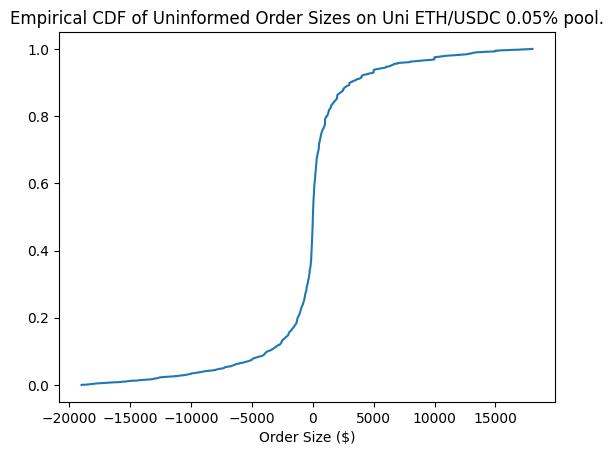

In [420]:
import matplotlib.pyplot as plt
k_ = 700
# np.sort(uninformed_trade_sizes)[10:-10]
plt.plot(np.sort(uninformed_trade_sizes)[k_:-k_], np.linspace(0, 1, len(uninformed_trade_sizes)-2*k_, endpoint=False))
plt.title("Empirical CDF of Uninformed Order Sizes on Uni ETH/USDC 0.05% pool.");
plt.xlabel("Order Size ($)");

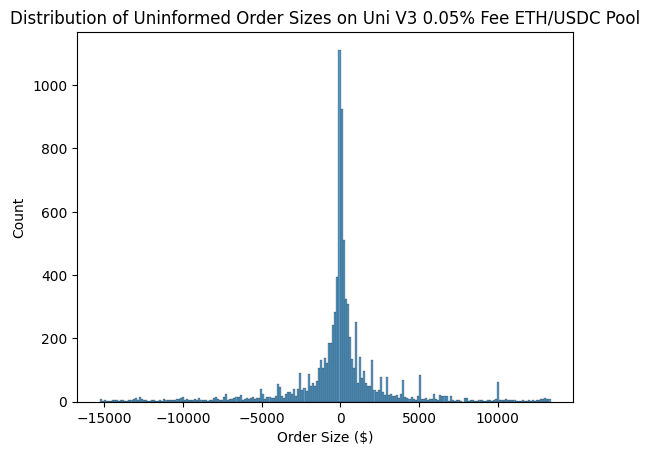

In [422]:
import seaborn as sns
k2_ = 800
sns.histplot(np.sort(uninformed_trade_sizes)[k2_:-k2_]);
plt.title("Distribution of Uninformed Order Sizes on Uni V3 0.05% Fee ETH/USDC Pool");
plt.xlabel("Order Size ($)");

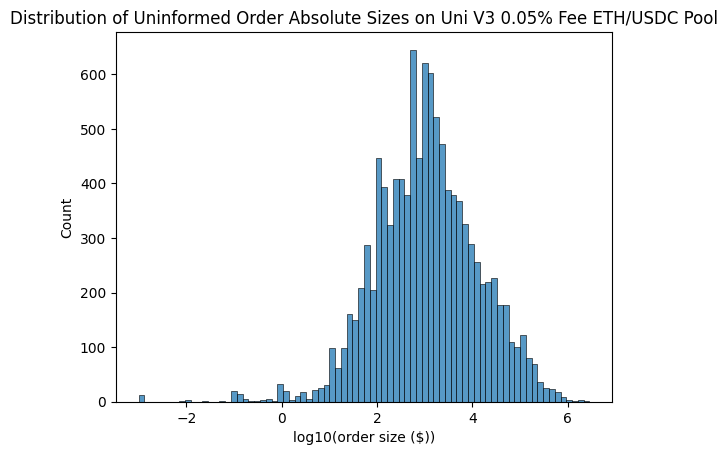

In [430]:
import seaborn as sns
k2_ = 800
sns.histplot(np.log10(np.abs(np.sort(uninformed_trade_sizes))));
plt.title("Distribution of Uninformed Order Absolute Sizes on Uni V3 0.05% Fee ETH/USDC Pool");
plt.xlabel("log10(order size ($))");

/tmp/ipykernel_1589/1243015213.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(np.abs(samples_)), bins=75);


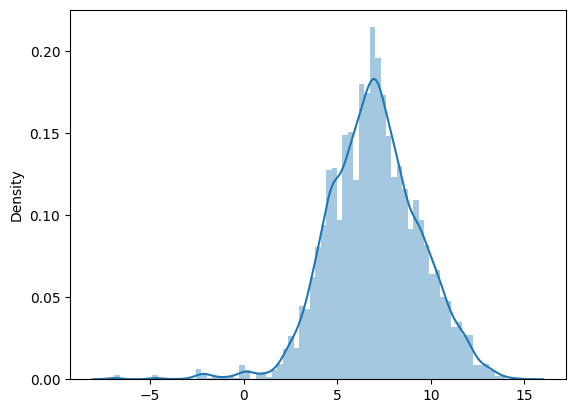

In [442]:
# sample from the ecdf
uninformed_sizes_sorted_ = np.sort(uninformed_trade_sizes)

samples_ = []
for _ in range(10_000):
    r_ = np.random.uniform(0, 1)
    i_ = int(r_ * len(uninformed_sizes_sorted_))
    v_ = uninformed_sizes_sorted_[i_]
    #print(r_, i_, len(uninformed_sizes_sorted_), v_)
    samples_.append(v_)

sns.distplot(np.log(np.abs(samples_)), bins=75);